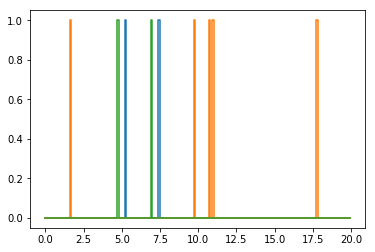

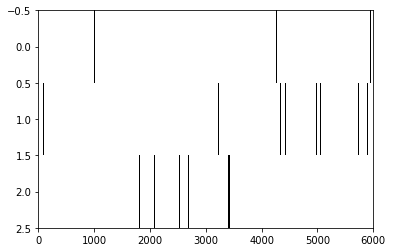

Number of events A:  75
Number of events B:  91
Lambda A:  0.125
Lambda B:  0.151666666667


In [1]:
import numpy as np
from scipy.stats import poisson
import random
import matplotlib.pyplot as plt

fps  =10

T = 600 # in seconds
tau = 0.05
win_t = np.arange(0, 2, 1/fps)

#random dataset
onepr = 1./70
a = np.random.choice([0,1], size=6000, p=[1-onepr, onepr])
b = np.random.choice([0,1], size=6000, p=[1-onepr, onepr])

#shifted dataset
shft = 5
c = np.hstack((a.copy()[shft:], np.zeros(shft)))
ind = np.random.choice(np.arange(0, fps*T, 1), size =1, replace = False)
c[ind] = 0

#time vector
time = np.arange(0,T,1/fps)
data = np.vstack((a,b,c))

plt.step(time[:200], a[:200])
plt.step(time[:200], b[:200])
plt.step(time[:200], c[:200])
plt.show()

plt.imshow(data, aspect = 'auto', cmap = 'binary')
plt.show()

#total number of events
na = sum(a) # number of spikes in a
nb = sum(b) #number of spikes in b 

print("Number of events A: ", na)
print("Number of events B: ", nb)

#rate of events
lambdaa = na/T
lambdab = nb/T
print("Lambda A: ", lambdaa)
print("Lambda B: ", lambdab)

In [2]:
def eventCoin(a, b, #two binary signals to compare
              win_t, #vector of time (s) for window
              na = None, nb = None, #number of total events in each comparitive vector
              ratetype = 'precursor', #precursor or trigger
              tau = 0, #lag coefficeint 
              fps = 10, #sampling rate, frames per sec
              verbose = True,
              veryVerbose = False):
    
    if na == None:
        na = sum(a)
    if nb == None:
        nb = sum(b)
    
    #find all indices for each event
    a_ind = [i for i, e in enumerate(a) if e != 0]
    b_ind = [i for i, e in enumerate(b) if e != 0]
    
    #convert window times to window frames
    win_fr = win_t * fps 
    
    #create index difference matrix
    ind_diff = np.zeros((len(a_ind), len(b_ind)))

    for i,inda in enumerate(a_ind): # rows
        for j,indb in enumerate(b_ind): # columns
            ind_diff [i,j]= inda - (tau*fps) - indb

    #replace all neg values with 0
    ind_diff[ind_diff< 0] = 0
    
    if veryVerbose:
        print('Size of difference array: ',ind_diff.shape)
        plt.imshow(ind_diff)
        plt.title('Difference in indices')
        plt.xlabel('indices from list a')
        plt.ylabel('indices from list b')
        plt.colorbar()
        plt.show()

    #create event matrix
    if ratetype == 'precursor':
        print('Calculating PRECURSOR coincidence \n ----------------------------------')

        events = np.zeros((ind_diff.shape[0], len(win_fr)))

        for i, win in enumerate(win_fr):
            if verbose:
                print('Calculating PRECURSOR coincidence rate for window ' + str(win/fps) +'sec(s)')
            for j in range(ind_diff.shape[0]):
                for k in range(ind_diff.shape[1]):
                    if ind_diff[j,k] > 0 and ind_diff[j,k] < win:
                        events[j,i] = 1

        rate_win = np.sum(events, axis=0)/na

    if ratetype == 'trigger':
        print('Calculating TRIGGER coincidence \n ----------------------------------')
        
        events = np.zeros((ind_diff.shape[1], len(win_fr)))
        
        for i, win in enumerate(win_fr):
            if verbose:
                print('Calculating coincidence rate for window ' + str(win/fps) +'sec(s)')
            for j in range(ind_diff.shape[0]):
                for k in range(ind_diff.shape[1]):
                    if ind_diff[j,k] > 0 and ind_diff[j,k] < win:
                        events[k,i] = 1
        
        rate_win = np.sum(events, axis=0)/nb
                    
    if verbose:
        plt.imshow(events, aspect = 'auto')
        plt.title('Event matrix')
        plt.xlabel('Time window')
        plt.ylabel('Coincidence per event')
        plt.show()

        plt.plot(win_t, rate_win)
        plt.title('Rates per time window')
        plt.xlabel('Time window (sec)')
        if ratetype == 'precursor':
            plt.ylabel('Precursor coincidence rate')
        if ratetype == 'trigger':
            plt.ylabel('Trigger coincidence rate')
        plt.show()

    return rate_win, na, nb

In [7]:
def getResults(rate_win,              
              win_t, #vector of time (s) for window
              na, #number of events in a
              nb, #number of event in b
              ratetype = 'precursor', #precursor or trigger
              T = 600, #length (s) of vector
              tau = 0, #lag coefficeint 
              fps = 10, #sampling rate, frames per sec
              verbose = True,
              veryVerbose = False):
    
    #expected rate and stdev of the rate
    if ratetype == 'precursor':
        rho = 1 - win_t/(T - tau)
        exp_rate = na*(1 - (rho)**nb)
        exp_std = np.sqrt(1/na*(1-rho**nb) * rho**nb)
    if ratetype == 'trigger':
        rho = 1 - win_t/(T - tau)
        exp_rate = nb*(1 - (rho)**na)
        exp_std = np.sqrt(1/nb*(1-rho**na) * rho**na)
    
    #quantiles used for graphing
    if verbose:
        perc = np.array([1, 2.5, 25, 50, 75, 97.5, 99])
        mark = ['k:', 'k-.', 'k--', 'k-', 'k--','k-.', 'k:']
        quantile = np.zeros((exp_rate.shape[0], perc.shape[0]))

    #number samples for null hypothesis
    k=10000

    sample = np.zeros((exp_rate.shape[0], k))
    results = np.zeros(exp_rate.shape[0])

    for i, r in enumerate(exp_rate):
        sample[i,:] = poisson.rvs(r, size=k)
        if ratetype == 'precursor':
            if verbose:
                quantile[i,:] = np.percentile(sample[i,:], perc)/na
            results[i] = sum(rate_win[i] < sample[i, :]/na)/k
        if ratetype == 'trigger':
            if verbose:
                quantile[i,:] = np.percentile(sample[i,:], perc)/nb
            results[i] = sum(rate_win[i] < sample[i, :]/nb)/k
        if veryVerbose:
            print(str(win_t[i]) + 'sec(s) time window produces a p value: ' + str(results[i]))

    if verbose:
        for j, r in enumerate(results):
            if r < 0.05:
                print(str(win_t[j]) + 'sec(s) time window produces a significant value: p=' + str(r))
    
    # plot sample values
    if veryVerbose:
        plt.imshow(sample, aspect = 'auto')
        plt.colorbar()
        plt.show()

    if verbose:
        for i in range(len(perc)):
            plt.plot(win_t, quantile[:, i], mark[i], label=perc[i])

        plt.plot(win_t, rate_win)
        plt.title('Rates per time window')
        plt.xlabel('Time window (sec)')
        plt.ylabel('Precursor coincidence rate')
        plt.legend()
        plt.show()
    
    return (results)

Calculating TRIGGER coincidence 
 ----------------------------------
Calculating coincidence rate for window 0.0sec(s)
Calculating coincidence rate for window 0.1sec(s)
Calculating coincidence rate for window 0.2sec(s)
Calculating coincidence rate for window 0.3sec(s)
Calculating coincidence rate for window 0.4sec(s)
Calculating coincidence rate for window 0.5sec(s)
Calculating coincidence rate for window 0.6sec(s)
Calculating coincidence rate for window 0.7sec(s)
Calculating coincidence rate for window 0.8sec(s)
Calculating coincidence rate for window 0.9sec(s)
Calculating coincidence rate for window 1.0sec(s)
Calculating coincidence rate for window 1.1sec(s)
Calculating coincidence rate for window 1.2sec(s)
Calculating coincidence rate for window 1.3sec(s)
Calculating coincidence rate for window 1.4sec(s)
Calculating coincidence rate for window 1.5sec(s)
Calculating coincidence rate for window 1.6sec(s)
Calculating coincidence rate for window 1.7sec(s)
Calculating coincidence rate fo

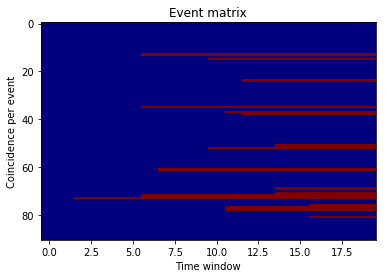

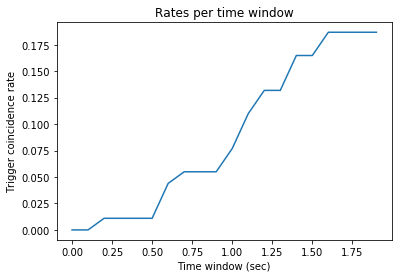

Calculating TRIGGER coincidence 
 ----------------------------------
Calculating coincidence rate for window 0.0sec(s)
Calculating coincidence rate for window 0.1sec(s)
Calculating coincidence rate for window 0.2sec(s)
Calculating coincidence rate for window 0.3sec(s)
Calculating coincidence rate for window 0.4sec(s)
Calculating coincidence rate for window 0.5sec(s)
Calculating coincidence rate for window 0.6sec(s)
Calculating coincidence rate for window 0.7sec(s)
Calculating coincidence rate for window 0.8sec(s)
Calculating coincidence rate for window 0.9sec(s)
Calculating coincidence rate for window 1.0sec(s)
Calculating coincidence rate for window 1.1sec(s)
Calculating coincidence rate for window 1.2sec(s)
Calculating coincidence rate for window 1.3sec(s)
Calculating coincidence rate for window 1.4sec(s)
Calculating coincidence rate for window 1.5sec(s)
Calculating coincidence rate for window 1.6sec(s)
Calculating coincidence rate for window 1.7sec(s)
Calculating coincidence rate fo

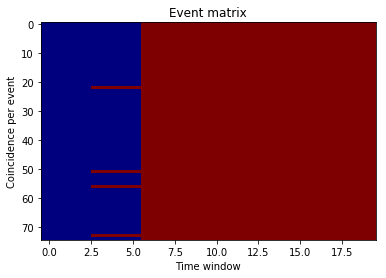

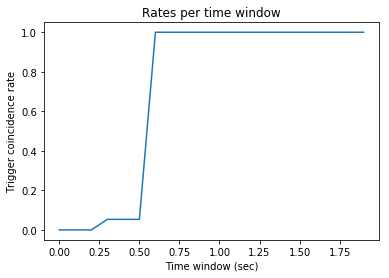

Calculating PRECURSOR coincidence 
 ----------------------------------
Calculating PRECURSOR coincidence rate for window 0.0sec(s)
Calculating PRECURSOR coincidence rate for window 0.1sec(s)
Calculating PRECURSOR coincidence rate for window 0.2sec(s)
Calculating PRECURSOR coincidence rate for window 0.3sec(s)
Calculating PRECURSOR coincidence rate for window 0.4sec(s)
Calculating PRECURSOR coincidence rate for window 0.5sec(s)
Calculating PRECURSOR coincidence rate for window 0.6sec(s)
Calculating PRECURSOR coincidence rate for window 0.7sec(s)
Calculating PRECURSOR coincidence rate for window 0.8sec(s)
Calculating PRECURSOR coincidence rate for window 0.9sec(s)
Calculating PRECURSOR coincidence rate for window 1.0sec(s)
Calculating PRECURSOR coincidence rate for window 1.1sec(s)
Calculating PRECURSOR coincidence rate for window 1.2sec(s)
Calculating PRECURSOR coincidence rate for window 1.3sec(s)
Calculating PRECURSOR coincidence rate for window 1.4sec(s)
Calculating PRECURSOR coincid

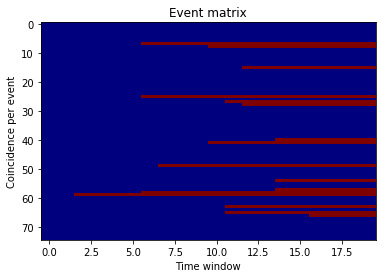

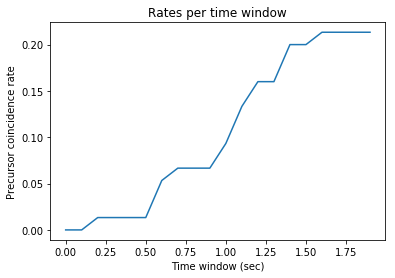

Calculating PRECURSOR coincidence 
 ----------------------------------
Calculating PRECURSOR coincidence rate for window 0.0sec(s)
Calculating PRECURSOR coincidence rate for window 0.1sec(s)
Calculating PRECURSOR coincidence rate for window 0.2sec(s)
Calculating PRECURSOR coincidence rate for window 0.3sec(s)
Calculating PRECURSOR coincidence rate for window 0.4sec(s)
Calculating PRECURSOR coincidence rate for window 0.5sec(s)
Calculating PRECURSOR coincidence rate for window 0.6sec(s)
Calculating PRECURSOR coincidence rate for window 0.7sec(s)
Calculating PRECURSOR coincidence rate for window 0.8sec(s)
Calculating PRECURSOR coincidence rate for window 0.9sec(s)
Calculating PRECURSOR coincidence rate for window 1.0sec(s)
Calculating PRECURSOR coincidence rate for window 1.1sec(s)
Calculating PRECURSOR coincidence rate for window 1.2sec(s)
Calculating PRECURSOR coincidence rate for window 1.3sec(s)
Calculating PRECURSOR coincidence rate for window 1.4sec(s)
Calculating PRECURSOR coincid

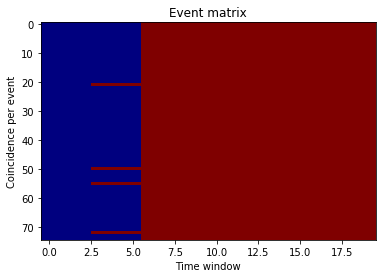

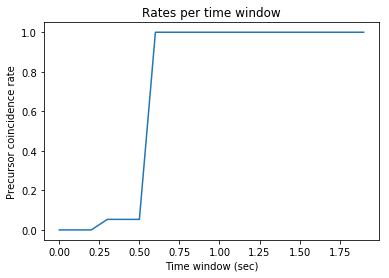

0.0sec(s) time window produces a significant value: p=0.0


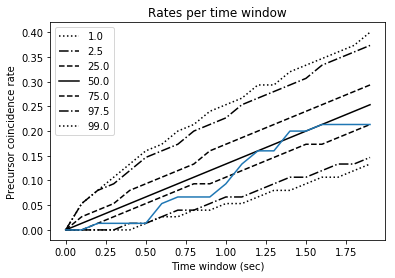

0.0sec(s) time window produces a significant value: p=0.0
0.6sec(s) time window produces a significant value: p=0.0
0.7sec(s) time window produces a significant value: p=0.0
0.8sec(s) time window produces a significant value: p=0.0
0.9sec(s) time window produces a significant value: p=0.0
1.0sec(s) time window produces a significant value: p=0.0
1.1sec(s) time window produces a significant value: p=0.0
1.2sec(s) time window produces a significant value: p=0.0
1.3sec(s) time window produces a significant value: p=0.0
1.4sec(s) time window produces a significant value: p=0.0
1.5sec(s) time window produces a significant value: p=0.0
1.6sec(s) time window produces a significant value: p=0.0
1.7sec(s) time window produces a significant value: p=0.0
1.8sec(s) time window produces a significant value: p=0.0
1.9sec(s) time window produces a significant value: p=0.0


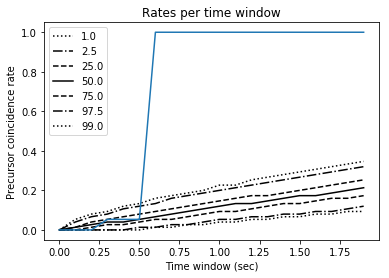

Time required for analysis:  5.028254985809326


In [8]:
import time

t0 = time.time()

rand, na, nb = eventCoin(a,b, win_t=win_t, ratetype ='trigger', verbose = True, veryVerbose = False)
shifted, na, nc = eventCoin(a,c, win_t=win_t, ratetype = 'trigger', verbose = True, veryVerbose=False)

rand, na, nb = eventCoin(a,b, win_t=win_t, ratetype ='precursor', verbose = True, veryVerbose = False)
shifted, na, nc = eventCoin(a,c, win_t=win_t, ratetype = 'precursor', verbose = True, veryVerbose=False)

# plt.plot(win_t, rand,  label='Random')
# plt.plot(win_t, shifted, label='Shifted')
# plt.title('Rates per time window')
# plt.xlabel('Time window (sce)')
# plt.ylabel('Precursor coincidence rate')
# plt.legend()
# plt.show()

rand_results = getResults(rand, win_t=win_t, na=na, nb=nb, verbose = True, veryVerbose = False)
shifted_results = getResults(shifted, win_t=win_t, na=na, nb=nc, verbose = True, veryVerbose = False)

print('Time required for analysis: ', time.time() - t0)